Active Trajectory Recommendation without Personalisation
=====

**NOTE: Before running this notebook, please run script `src/ijcai15_setup.py` to setup data properly.**

<a id='sec1'></a>

# 1. Overview

### Features
Transition Features
1. POI category (a transition matrix between different categories)
1. POI popularity (a transition matrix between different class of popularity)
1. POI pair distance (a transition matrix between different class of distance)

### Recommend Trajectories
Given (start, end) and trajectory length $l$ for a specific user $u$, we'll recommend a trajectory to user $u$ as follows:
- Compute/enumerate all trajectories of length $l$ with (start, end) as candidates
- Use a uniform prior for all candidates
- Compute the likelihood of candidates using the above transition features estimated from travelling sequences in the training set
- Sort candidates by their posterior probabilities (i.e. $\text{prior} \times \text{likelihood}$) in descending order
- Recommend a trajectory from the top $K$ (e.g. 5) candidates with probability proportional to its posterior

**NOTE** that we use the same leave-one-out cross validation approach described in the [ijcai15 paper](#https://sites.google.com/site/limkwanhui/publications/2015-IJCAI-personalTour.pdf?attredirects=0), concretely, for each user $u$ in the dataset, choose one trajectory (length >= 3) from all trajectories of $u$ uniformly at random, this trajectory is used as the ground truth to measure the performance of the recommendation (i.e. compute the [precision, recall and F1-score](./ijcai15.ipynb#sec2.1)), all other trajectories are used to train/estimate parameters. So the training set will change when iterating through all users.

### Notations

- $Traj$: a trajectory
- $\lvert Traj \rvert$: the number of POIs in trajectory $Traj$
- $P_s$: the `start` (first) POI of a trajectory
- $P_e$: the `end` (last) POI of a trajectory
- $u$: a specific user
- $\textbf{x}$: an example
- $\textbf{y}$: label of example $\textbf{x}$

- Example: $\textbf{x} = (P_s, P_e, \lvert Traj \rvert)$
- Label of Example: $\textbf{y} = Traj$
- Assume that all examples are i.i.d.

<a id='sec2'></a>

# 2. Load Data

In [367]:
%matplotlib inline

import os
import re
import sys
import math
import random
import pickle
import pandas as pd
import numpy as np
import scipy.misc
#from numba import jit
import pylab
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import Parallel, delayed
from scipy.optimize import minimize, OptimizeResult, fmin_l_bfgs_b, fmin, fmin_powell

In [3]:
#nfeatures = 8 # number of features
EPS = 1e-12 # smooth, deal with 0 probability
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)

In [4]:
data_dir = 'data/data-ijcai15'
fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [5]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-' + suffix + '.pkl')
frand = os.path.join(data_dir, 'F1-rand-' + suffix + '.pkl')
flc = os.path.join(data_dir, 'F1-lc-' + suffix + '.pkl')
fse = os.path.join(data_dir, 'F1-se-' + suffix + '.pkl')
fid = os.path.join(data_dir, 'F1-id-' + suffix + '.pkl')
forand = os.path.join(data_dir, 'seq-rand-' + suffix + '.pkl')
folc = os.path.join(data_dir, 'seq-lc-' + suffix + '.pkl')
fose = os.path.join(data_dir, 'seq-se-' + suffix + '.pkl')
foid = os.path.join(data_dir, 'seq-id-' + suffix + '.pkl')

In [6]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
#traj.head()

In [7]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Osak,7747,17.215556,27,1115,2.477778,450


<a id='sec2.1'></a>

## 2.1 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [8]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [9]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [10]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
#poi_all.to_csv(fpoi, index=True)

<a id='sec2.2'></a>

## 2.2 Construct Travelling Sequences

In [11]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10297518@N00,1,20,1277719324,1277720832,6,1508
1,10307040@N08,2,6,1382608644,1382608644,1,0
2,10307040@N08,2,8,1382607812,1382607812,1,0
3,10307040@N08,2,21,1382607761,1382607774,2,13
4,10307040@N08,2,22,1382607879,1382608628,9,749


In [12]:
seq_user = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_user.reset_index(inplace=True)
seq_user.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_user.set_index('seqID', inplace=True)
#seq_user.head()

In [13]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

<a id='sec3'></a>

# 3. Compute Transition Probabilities

<a id='sec3.1'></a>

## 3.1 Basic Definitions

- $\text{Pr}(\text{Cat}_j ~\vert~ \text{Cat}_i)$:
   the transition probability from a POI of category $\text{Cat}_i$ to a POI of category $\text{Cat}_j$
- $\text{Pr}(\text{Pop}_j ~\vert~ \text{Pop}_i)$:
   the transition probability from a POI of Popularity class $\text{Pop}_i$ to a POI of Popularity class $\text{Pop}_j$
- $\text{Pr}(\text{Dist}_j ~\vert~ \text{Dist}_i)$:
   the transition probability from a POI-POI pair with distance (between the two) class $\text{Dist}_i$ to a POI-POI pair with distance (between the two) class $\text{Dist}_j$

Smoothing by adding each cell a small number (i.e. $0.2$ times the minimum value of that row) if there exists a zero cell, adding a uniform count (i.e. 1) for all-zero rows.

In [385]:
def smooth_obsmat(obsmat):
    assert(isinstance(obsmat, pd.DataFrame))
    for row in range(obsmat.index.shape[0]):
        nonzeroidx = np.nonzero(obsmat.iloc[row])[0].tolist()
        if len(nonzeroidx) == 0: # all zero in this row
            obsmat.iloc[row] = 1  # smooth
        elif len(nonzeroidx) < obsmat.columns.shape[0]: # some cells are zero
            minv = np.min(obsmat.iloc[row, nonzeroidx])
            EPS = 0.2 * minv  # row-specific smooth factor
            obsmat.iloc[row] += EPS
    return obsmat

In [386]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    assert(np.all(transmat.dtypes == np.float))
    for row in range(transmat.index.shape[0]):
        rowsum = np.sum(transmat.iloc[row])
        assert(rowsum > 0)
        transmat.iloc[row] /= rowsum
    return transmat

Compute posterior: $\log(\text{posterior}) = \log(\text{likelihood}) + \log(\text{prior})$ and then normalise.

In [387]:
def calc_log_transmat(obs_log_transmat, prior_log_transmat):
    assert(isinstance(obs_log_transmat, pd.DataFrame))
    assert(isinstance(prior_log_transmat, pd.DataFrame))
    assert(np.all(obs_log_transmat.get_values() < 0))
    assert(np.all(prior_log_transmat.get_values() < 0))
    assert(np.all(obs_log_transmat.index == prior_log_transmat.index))
    assert(np.all(obs_log_transmat.columns == prior_log_transmat.columns))
    log_transmat = obs_log_transmat + prior_log_transmat
    for row in range(log_transmat.index.shape[0]):
        logrowsum = scipy.misc.logsumexp(log_transmat.iloc[row]) # logsumexp(vec) = log(sum(exp(vec)))
        log_transmat.iloc[row] -= logrowsum # normalisation
    return log_transmat

<a id='sec3.2'></a>

## 3.2 Transition Probabilities between POI Categories

We model transition probabilities between POI categories, i.e.
$\text{Pr}(\text{Cat}_{\text{POI}_j} ~\vert~ \text{Cat}_{\text{POI}_i})$.

We count the number of transition first, then normalise each row while taking care of zero by smoothing.

Version 1: update the transition matrix using the current queried sequence and the previous posterior as prior.

In [402]:
def calc_poi_cat_log_transmat1(seq, poi_info, poi_cats, seq_all, prior_log_transmat=None):
    assert(len(poi_cats) > 0)
    
    if len(seq) == 0:
        return pd.DataFrame(data=np.log((1/len(poi_cats)) * np.ones((len(poi_cats), len(poi_cats)), \
                                 dtype=np.float)), index=poi_cats, columns=poi_cats) # uniform prior
    
    assert(len(seq) > 1)
    
    # observation
    poi_cat_obsmat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                  index=poi_cats, columns=poi_cats)
    for j in range(len(seq)-1):
        poi1 = seq[j]
        poi2 = seq[j+1]
        cat1 = poi_info.loc[poi1, 'poiTheme']
        cat2 = poi_info.loc[poi2, 'poiTheme']
        poi_cat_obsmat.loc[cat1, cat2] += 1
    poi_cat_obsmat = smooth_obsmat(poi_cat_obsmat)
    
    if prior_log_transmat is None: 
        prior_log_transmat = pd.DataFrame(data=np.log((1/len(poi_cats)) * np.ones((len(poi_cats), len(poi_cats)), \
                                          dtype=np.float)), index=poi_cats, columns=poi_cats) # uniform prior
        
    return calc_log_transmat(np.log(normalise_transmat(poi_cat_obsmat)), prior_log_transmat)

Version 2: calculate the transition matrix using all observed sequences up to now and an uniform prior.

In [389]:
def calc_poi_cat_log_transmat2(seqid_set, poi_info, poi_cats, seq_all):
    assert(len(poi_cats) > 0)
    
    # observation
    poi_cat_obsmat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                  index=poi_cats, columns=poi_cats)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            cat1 = poi_info.loc[poi1, 'poiTheme']
            cat2 = poi_info.loc[poi2, 'poiTheme']
            poi_cat_obsmat.loc[cat1, cat2] += 1
    poi_cat_obsmat = smooth_obsmat(poi_cat_obsmat)
    
    # uniform prior
    prior_log_transmat = pd.DataFrame(data=np.log((1/len(poi_cats)) * np.ones((len(poi_cats), len(poi_cats)), \
                                      dtype=np.float)), index=poi_cats, columns=poi_cats)
    
    return calc_log_transmat(np.log(normalise_transmat(poi_cat_obsmat)), prior_log_transmat)

<a id='sec3.3'></a>

## 3.3 Transition Probabilities between POI Popularity Classes

We model transition probabilities between POI popularities, i.e.
$\text{Pr}(\text{Pop}_{\text{POI}_j} ~\vert~ \text{Pop}_{\text{POI}_i})$
after discretizing POI popularities.

In [390]:
def calc_poi_info(seqid_set, poi_all, seq_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'seqID']].copy()
    poi_info = poi_info.groupby('poiID').agg(np.size)
    poi_info.rename(columns={'seqID':'popularity'}, inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']  
    return poi_info

### 3.3.2 Compute Transition Probabilities

Version 1: update the transition matrix using the current queried sequence and the previous posterior as prior.

In [404]:
def calc_poi_pop_log_transmat1(seq, poi_info, bins_pop, seq_all, prior_log_transmat=None):
    pop_class = np.arange(1, len(bins_pop))
    
    if len(seq) == 0:
        return pd.DataFrame(data=np.log((1/len(pop_class)) * np.ones((len(pop_class), len(pop_class)), \
                                 dtype=np.float)), index=pop_class, columns=pop_class) # uniform prior
    
    assert(len(seq) > 1)
    
    # observation
    poi_pop_obsmat = pd.DataFrame(data=np.zeros((len(pop_class), len(pop_class)), dtype=np.float), \
                                  index=pop_class, columns=pop_class)
    for j in range(len(seq)-1):
        poi1 = seq[j]
        poi2 = seq[j+1]
        pop1 = poi_info.loc[poi1, 'popularity']
        pop2 = poi_info.loc[poi2, 'popularity']
        pc1 = np.digitize([pop1], bins_pop)[0]
        pc2 = np.digitize([pop2], bins_pop)[0]
        poi_pop_obsmat.loc[pc1, pc2] += 1
    poi_pop_obsmat = smooth_obsmat(poi_pop_obsmat)
    
    if prior_log_transmat is None:
        prior_log_transmat = pd.DataFrame(data=np.log((1/len(pop_class)) * np.ones((len(pop_class), len(pop_class)), \
                                          dtype=np.float)), index=pop_class, columns=pop_class) # uniform prior
    
    return calc_log_transmat(np.log(normalise_transmat(poi_pop_obsmat)), prior_log_transmat)

Version 2: calculate the transition matrix using all observed sequences up to now and an uniform prior.

In [405]:
def calc_poi_pop_log_transmat2(seqid_set, poi_info, bins_pop, seq_all):
    pop_class = np.arange(1, len(bins_pop))
    
    # observation
    poi_pop_obsmat = pd.DataFrame(data=np.zeros((len(pop_class), len(pop_class)), dtype=np.float), \
                                  index=pop_class, columns=pop_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            pop1 = poi_info.loc[poi1, 'popularity']
            pop2 = poi_info.loc[poi2, 'popularity']
            pc1 = np.digitize([pop1], bins_pop)[0]
            pc2 = np.digitize([pop2], bins_pop)[0]
            poi_pop_obsmat.loc[pc1, pc2] += 1
    poi_pop_obsmat = smooth_obsmat(poi_pop_obsmat)
    
    # uniform prior
    prior_log_transmat = pd.DataFrame(data=np.log((1/len(pop_class)) * np.ones((len(pop_class), len(pop_class)), \
                                      dtype=np.float)), index=pop_class, columns=pop_class)
    
    return calc_log_transmat(np.log(normalise_transmat(poi_pop_obsmat)), prior_log_transmat)

<a id='sec3.4'></a>

## 3.4 Transition Probabilities between POI Pair Distance Classes

We model transition probabilities between different POI pair distances, i.e.
$\text{Pr}(\text{Dist}_{\text{POI}_{i} \to \text{POI}_{i+1}} ~\vert~ \text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i})$
after discretize POI pair distances.

### TODO: Improve the distance calculation using Google maps [distance API](https://developers.google.com/maps/documentation/distance-matrix/intro) with different [travel modes](https://developers.google.com/maps/documentation/distance-matrix/intro#travel_modes) demonstrated [here](https://jakevdp.github.io/blog/2015/10/17/analyzing-pronto-cycleshare-data-with-python-and-pandas/).

### 3.4.2 Compute Transition Probabilities

Version 1: update the transition matrix using the current queried sequence and the previous posterior as prior.

In [406]:
def calc_poipair_dist_log_transmat1(seq, bins_dist, poi_distmat, seq_all, prior_log_transmat=None):
    dist_class = np.arange(1, len(bins_dist))
    if len(seq) == 0:
        return pd.DataFrame(data=np.log((1/len(dist_class))*np.ones((len(dist_class), len(dist_class)), \
                                 dtype=np.float)), index=dist_class, columns=dist_class) # uniform prior
    
    assert(len(seq) > 1)
    
    # observation
    poipair_dist_obsmat = pd.DataFrame(data=np.zeros((len(dist_class), len(dist_class)), dtype=np.float), \
                                       index=dist_class, columns=dist_class)
    if len(seq) >= 3:
        for j in range(1, len(seq)-1):
            poi1 = seq[j-1]
            poi2 = seq[j]
            poi3 = seq[j+1]
            dist12 = poi_distmat.loc[poi1, poi2]
            dist23 = poi_distmat.loc[poi2, poi3]
            dc12 = np.digitize([dist12], bins_dist)[0]
            dc23 = np.digitize([dist23], bins_dist)[0]
            poipair_dist_obsmat.loc[dc12, dc23] += 1
    poipair_dist_obsmat = smooth_obsmat(poipair_dist_obsmat)
    
    if prior_log_transmat is None:
        prior_log_transmat = pd.DataFrame(data=np.log((1/len(dist_class))*np.ones((len(dist_class), len(dist_class)), \
                                          dtype=np.float)), index=dist_class, columns=dist_class) # uniform prior
        
    return calc_log_transmat(np.log(normalise_transmat(poipair_dist_obsmat)), prior_log_transmat)

Version 2: calculate the transition matrix using all observed sequences up to now and an uniform prior.

In [407]:
def calc_poipair_dist_log_transmat2(seqid_set, bins_dist, poi_distmat, seq_all):
    dist_class = np.arange(1, len(bins_dist))
    
    # observation
    poipair_dist_obsmat = pd.DataFrame(data=np.zeros((len(dist_class), len(dist_class)), dtype=np.float), \
                                       index=dist_class, columns=dist_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) < 3: continue
        for j in range(1, len(seq)-1):
            poi1 = seq[j-1]
            poi2 = seq[j]
            poi3 = seq[j+1]
            dist12 = poi_distmat.loc[poi1, poi2]
            dist23 = poi_distmat.loc[poi2, poi3]
            dc12 = np.digitize([dist12], bins_dist)[0]
            dc23 = np.digitize([dist23], bins_dist)[0]
            poipair_dist_obsmat.loc[dc12, dc23] += 1
    poipair_dist_obsmat = smooth_obsmat(poipair_dist_obsmat)
    
    # uniform prior
    prior_log_transmat = pd.DataFrame(data=np.log((1/len(dist_class))*np.ones((len(dist_class), len(dist_class)), \
                                      dtype=np.float)), index=dist_class, columns=dist_class)
            
    return calc_log_transmat(np.log(normalise_transmat(poipair_dist_obsmat)), prior_log_transmat)

<a id='sec4'></a>

# 4. Compute Trajectory Likelihood

Log likelihood of trajectory $[\text{POI}_1, \text{POI}_2, \dots, \text{POI}_i, ..., \text{POI}_N]$ is defined as
\begin{align}
\text{loglikelihood} = &~
w_1 \sum_{i=1}^{N-1} \log(\text{Pr}(\text{Cat}_{\text{POI}_{i+1}} ~\vert~ \text{Cat}_{\text{POI}_i})) + 
w_2 \sum_{i=1}^{N-1} \log(\text{Pr}(\text{Pop}_{\text{POI}_{i+1}} ~\vert~ \text{Pop}_{\text{POI}_i})) + \\
&~ w_3 \sum_{i=2}^{N-1} \log(\text{Pr}(\text{Dist}_{\text{POI}_i \to \text{POI}_{i+1}} ~\vert~ 
\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i}))
+ \log(\text{Pr}(\text{POI}_1)) 
\end{align}

where $w_i \in \mathbb{R}$ are weights and $\text{Pr}(\text{POI}_1)$ is the prior of $\text{POI}_1$, 
we assume $\text{Pr}(\text{POI}_1)=1.0$.

In [395]:
def calc_seq_loglikelihood(seq, weights, poi_all, poi_info, bins_pop, bins_dist, poi_distmat, \
                           poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat):
    assert(len(seq) > 1)
    assert(len(weights) == 3)
    #assert(abs(1 - sum(weights)) < 1e-9) # sum(weights) == 1 # No longer assume that
    
    cat1 = poi_all.loc[seq[0], 'poiTheme']
    cat2 = poi_all.loc[seq[1], 'poiTheme']
    logL = weights[0] * poi_cat_log_transmat.loc[cat1, cat2]
    
    pop1 = 1; pop2 = 1  # just this very observation if not in poi_info
    if seq[0] in poi_info.index:
        pop1 = poi_info.loc[seq[0], 'popularity']
    if seq[1] in poi_info.index:
        pop2 = poi_info.loc[seq[1], 'popularity']
    pc1 = np.digitize([pop1], bins_pop)[0]
    pc2 = np.digitize([pop2], bins_pop)[0]
    logL += weights[1] * poi_pop_log_transmat.loc[pc1, pc2]
    
    for j in range(1, len(seq)-1):
        poi1 = seq[j-1]
        poi2 = seq[j]
        poi3 = seq[j+1]
        cat2 = poi_all.loc[poi2, 'poiTheme']
        cat3 = poi_all.loc[poi3, 'poiTheme']
        logL += weights[0] * poi_cat_log_transmat.loc[cat2, cat3]
        
        pop2 = 1; pop3 = 1
        if poi2 in poi_info.index:
            pop2 = poi_info.loc[poi2, 'popularity']
        if poi3 in poi_info.index:
            pop3 = poi_info.loc[poi3, 'popularity']
        pc2 = np.digitize([pop2], bins_pop)[0]
        pc3 = np.digitize([pop3], bins_pop)[0]
        logL += weights[1] * poi_pop_log_transmat.loc[pc2, pc3]
        
        dist12 = poi_distmat.loc[poi1, poi2]
        dist23 = poi_distmat.loc[poi2, poi3]
        dc12 = np.digitize([dist12], bins_dist)[0]
        dc23 = np.digitize([dist23], bins_dist)[0]
        logL += weights[2] * poipair_dist_log_transmat.loc[dc12, dc23]
    return logL

<a id='sec5'></a>

# 5. Trajectory Recommendation & Evaluation

### Cost function

Learn weights by optimising an cost function.

For convenience, example and its label are defined as:
- Example: $\textbf{x} = (P_s, P_e, \lvert Traj \rvert)$
- Label of Example: $\textbf{y} = Traj$

Cost function is defined as
\begin{equation}
J(\mathbf{w}) = C \sum_i \left( 1 - 
\frac{\lvert \text{set}(\mathbf{y}^{*(i)}) \cap \text{set}(\mathbf{y}^{(i)}) \rvert -2}
     {\lvert \text{set}(\mathbf{y}^{*(i)}) \cup \text{set}(\mathbf{y}^{(i)}) \rvert -2} \right)
\end{equation}

where $\mathbf{w}$ are weights and $C$ is a constant, $\mathbf{y}^{*(i)}$ is the most likely label of $\textbf{x}$ 
as defined below, $\text{set}(\mathbf{y})$ denotes the set of POIs in the recommended trajectory $\textbf{y}$.

\begin{equation}
\mathbf{y}^{*(i)} = 
\text{arg}\max_{\hat{\mathbf{y}}^{(i)}} \text{Pr}(\hat{\mathbf{y}}^{(i)} \vert \mathbf{x}; \mathbf{w}; \Theta)
\end{equation}

Parameters $\Theta$ are estimated using the `estimate_parameter` function defined below,
and weights $\mathbf{w}$ are learned by minimizing the above cost function on training set.

**Problem**: the cost function is not differentiable, how to optimize it?

Parameter estimation of the Markov Chain.

Version 1: update the transition matrix using the current queried sequence and the previous posterior as prior.

In [396]:
def estimate_parameter1(seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all, \
                        poi_cat_log_prior=None, poi_pop_log_prior=None, poipair_dist_log_prior=None):
    # compute POI info using training set
    poi_info = calc_poi_info(seqid_set_training, poi_all, seq_all)
    
    # the last sequence is the result of current querying
    seq = []
    if len(seqid_set_training) > 0:
        seqid = seqid_set_training[-1]
        seq = extract_seq(seqid, seq_all)
    
    # compute POI category transition matrix
    poi_cat_log_transmat = calc_poi_cat_log_transmat1(seq, poi_info, poi_cats, seq_all, poi_cat_log_prior)
    
    # compute POI popularity transition matrix
    poi_pop_log_transmat = calc_poi_pop_log_transmat1(seq, poi_info, bins_pop, seq_all, poi_pop_log_prior)
    
    # compute POI pair distance transition matrix
    poipair_dist_log_transmat = calc_poipair_dist_log_transmat1(seq, bins_dist, poi_distmat, seq_all, \
                                                                poipair_dist_log_prior)
    
    return (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)

Version 2: calculate the transition matrix using all observed sequences up to now and an uniform prior.

In [397]:
def estimate_parameter2(seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all):
    # compute POI info using training set
    poi_info = calc_poi_info(seqid_set_training, poi_all, seq_all)
    
    # compute POI category transition matrix
    poi_cat_log_transmat = calc_poi_cat_log_transmat2(seqid_set_training, poi_info, poi_cats, seq_all)
    
    # compute POI popularity transition matrix
    poi_pop_log_transmat = calc_poi_pop_log_transmat2(seqid_set_training, poi_info, bins_pop, seq_all)
    
    # compute POI pair distance transition matrix
    poipair_dist_log_transmat = calc_poipair_dist_log_transmat2(seqid_set_training, bins_dist, poi_distmat, seq_all)
    
    return (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)

Enumerate trajectories of the same (start, end) and length (3, 4 or 5) with respect to an actual sequence.

In [398]:
def enum_seq345(start, end, length, poi_list): 
    assert(length in {3, 4, 5})
    p0 = start
    pN = end
    
    # enumerate sequences with length 3
    if length == 3:
        return [[p0, p, pN] \
                for p in poi_list if p not in {p0, pN}]
    
    # enumerate sequences with length 4
    if length == 4:
        return [[p0, p1, p2, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN}]
    
    # enumerate sequences with length 5
    if length == 5:
        return [[p0, p1, p2, p3, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN} \
                for p3 in poi_list if p3 not in {p0, p1, p2, pN}]

In [399]:
def parse_seqstr(seqstr):
    term = re.sub('[ \[\]]', '', seqstr).split(',')
    return [int(x) for x in term]

With uniform prior, the posterior probability of trajectory is proportional to its likelihood.

In [400]:
def recommend_trajectory(start, end, length, weights, poi_list, poi_info, bins_pop, bins_dist, poi_distmat, \
                         poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat):
    assert(len(weights) == 3)
    # enumerate trajectory
    enum_seqs = enum_seq345(start, end, length, poi_list)
    
    # compute log likelihood   
    logL = []
    for seq in enum_seqs:
        logl = calc_seq_loglikelihood(seq, weights, poi_all, poi_info, bins_pop, bins_dist, poi_distmat, \
                                      poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        logL.append(logl)
    
    # sanity check: passed
    seq1 = [10, 21, 28, 22]
    pops = []
    for i in range(len(seq1)):
        if seq1[i] in poi_info.index: pops.append(poi_info.loc[seq1[i], 'popularity'])
        else: pops.append(1)
    cats = [poi_all.loc[x, 'poiTheme'] for x in seq1] # use the ugly global variable
    dc12 = np.digitize([poi_distmat.loc[seq1[0], seq1[1]]], bins_dist)[0]
    dc23 = np.digitize([poi_distmat.loc[seq1[1], seq1[2]]], bins_dist)[0]
    dc34 = np.digitize([poi_distmat.loc[seq1[2], seq1[3]]], bins_dist)[0]
    s1 = weights[0] * (\
         poi_cat_log_transmat.loc[cats[0], cats[1]] + poi_cat_log_transmat.loc[cats[1], cats[2]] + \
         poi_cat_log_transmat.loc[cats[2], cats[3]]) + \
         weights[1] * (\
         poi_pop_log_transmat.loc[np.digitize([pops[0]], bins_pop)[0], np.digitize([pops[1]], bins_pop)[0]] + \
         poi_pop_log_transmat.loc[np.digitize([pops[1]], bins_pop)[0], np.digitize([pops[2]], bins_pop)[0]] + \
         poi_pop_log_transmat.loc[np.digitize([pops[2]], bins_pop)[0], np.digitize([pops[3]], bins_pop)[0]])
    s2 = weights[2] * (poipair_dist_log_transmat.loc[dc12, dc23] + poipair_dist_log_transmat.loc[dc23, dc34])
    logL1 = calc_seq_loglikelihood(seq1, weights, poi_all, poi_info, bins_pop, bins_dist, poi_distmat, \
                                   poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
    #print(s1+s2, '-', logL1, '=', s1+s2-logL1); sys.stdout.flush()
    assert(abs(s1+s2-logL1) < 1e-9)
    
    # dataframe of enumerated trajectories
    enum_seq_df = pd.DataFrame(data=np.array(logL), index=[str(x) for x in enum_seqs], columns=['logLikelihood'])
    
    # sort by loglikeilihood in descending order
    enum_seq_df.sort(columns=['logLikelihood'], ascending=False, inplace=True)
    
    # recommend trajectory
    probs = enum_seq_df['logLikelihood'].get_values(); #print(probs)
    probs = np.exp(probs)
    probs /= np.sum(probs); #print(probs)
    #enum_seq_df['probability'] = probs
    
    # recommend a trajectory with probability proportional to its posterior (i.e. likelihood when prior is uniform)
    #sample = np.random.multinomial(1, probs) # catgorical/multinoulli distribution, multinomial distribution (n=1)
    #idx = sample.nonzero()[0][0]
    #return (parse_seqstr(enum_seq_df.index[idx]), probs[idx]) # return the recommended sequence and its probability
    
    # recommend the topk trajectories with their probabilities
    k = 10
    if enum_seq_df.shape[0] < k: 
        k = enum_seq_df.shape[0]
    result_df = enum_seq_df.iloc[0:k].copy()
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index':'sequence'}, inplace=True)
    result_df.drop('logLikelihood', axis=1, inplace=True)
    result_df['probability'] = probs[0:k]
    return result_df

Use F1 measure defined [here](./ijcai15.ipynb#sec2.1) to evaluate the performance of recommender.

In [30]:
def calc_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    actset = set(seq_act)
    recset = set(seq_rec)
    intersect = actset & recset
    recall = len(intersect) / len(seq_act)
    precision = len(intersect) / len(seq_rec)
    F1score = 2. * precision * recall / (precision + recall)
    return F1score

Evaluation on test set.

In [31]:
def evaluate_parallel(seqid_set, weights, poi_list, poi_info, seq_all, bins_pop, bins_dist, poi_distmat, \
                      poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat):
    seq_act_list = [extract_seq(seqid, seq_all) for seqid in seqid_set]
    seq_rec_df_list = Parallel(n_jobs=-2)(delayed(recommend_trajectory)\
                      (seq[0], seq[-1], len(seq), weights, poi_list, poi_info, bins_pop, bins_dist, poi_distmat, \
                       poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) \
                      for seq in seq_act_list)    
    seq_rec_list = [parse_seqstr(seq_rec_df.iloc[0]['sequence']) for seq_rec_df in seq_rec_df_list]
    assert(len(seq_act_list) == len(seq_rec_list))
    #F1scores = [calc_F1score(seq_act_list[x], seq_rec_list[x]) for x in range(len(seq_act_list))] # OK
    F1scores = Parallel(n_jobs=-2)(delayed(calc_F1score)\
               (seq_act_list[x], seq_rec_list[x]) for x in range(len(seq_act_list))) # OK
                                   
    return F1scores

In [440]:
def evaluate_random(seqid_set, poi_list, seq_all):
    seq_act_list = [extract_seq(seqid, seq_all) for seqid in seqid_set]
    seq_rec_list = []
    for seq in seq_act_list:
        enum_seqs = enum_seq345(seq[0], seq[-1], len(seq), poi_list)
        seq_rec_list.append(random.choice(enum_seqs))    
    assert(len(seq_act_list) == len(seq_rec_list))
    F1scores = Parallel(n_jobs=-2)(delayed(calc_F1score)\
               (seq_act_list[x], seq_rec_list[x]) for x in range(len(seq_act_list)))
    return F1scores

Compute the total cost, 
1. use `F1` based metric as cost,
1. use the cost function defined above.

In [353]:
def calc_cost1(weights, seqid_set, poi_list, poi_info, seq_all, bins_pop, bins_dist, poi_distmat, \
              poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat):
    F1scores = evaluate_parallel(seqid_set, weights, poi_list, poi_info, seq_all, bins_pop, bins_dist, poi_distmat, \
                                 poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
    C = 1e3 # 0.61, 0.60, (0.59, 0.11), (0.63, 0.12), (0.65, 0.08)
    #return C * np.sum(1 - np.array(F1scores))
    #return C * ((1 - np.mean(F1scores)) + np.std(F1scores))
    #return C * np.sum(np.array(F1scores) < 0.6)
    return C * np.sum(np.array(F1scores) < 0.7) 
    #return C * np.sum(np.array(F1scores) < 0.8)    

In [354]:
def calc_cost2(weights, seqid_set, poi_list, poi_info, seq_all, bins_pop, bins_dist, poi_distmat, \
              poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat):
    seq_act_list = [extract_seq(seqid, seq_all) for seqid in seqid_set]
    seq_rec_df_list = Parallel(n_jobs=-2)(delayed(recommend_trajectory)\
                      (seq[0], seq[-1], len(seq), weights, poi_list, poi_info, bins_pop, bins_dist, poi_distmat, \
                       poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) \
                      for seq in seq_act_list)    
    seq_rec_list = [parse_seqstr(seq_rec_df.iloc[0]['sequence']) for seq_rec_df in seq_rec_df_list]
    assert(len(seq_act_list) == len(seq_rec_list))
    costs = [(1-(len(set(seq_act_list[x]) & set(seq_rec_list[x]))-2) / \
                (len(set(seq_act_list[x]) | set(seq_rec_list[x]))-2)) for x in range(len(seq_act_list))]
    C = 1e3 
    #return C * np.sum(costs)
    return C * np.dot(costs, costs)

<a id='sec6'></a>

# 6. Active Learning without Personalisation

**Two Approaches**

**Approach ONE** 
1. At each query step, setting the `prior` as the `posterior` of the previous step 
(using an uniform `prior` at the first step), 
1. compute the `likelihood` using the trajectory gotten by current querying, 
1. multiplying the `likelihood` and the `prior` to get the `posterior`, 
1. using maximum a posteriori (MAP) to recommend trajectory and evaluate the performance on test set.

**Approach TWO**
1. At each query step, using all trajectories (including the one get by current querying) 
in current training set to compute the `likelihood`, 
1. multiplying the `likelihood` and an uniform `prior` to get the `posterior`, 
1. using maximum a posteriori (MAP) to recommend trajectory and evaluate the performance on test set.

**NOTE** that the above `prior`, `likelihood` and `posterior` are corresponding to the parameters of the probabilistic model, i.e. the transition probabilities of three Markov Chains (POI category, POI popularity, POI pair distance).

**Question:** : are they equivalent?  
Generally **NO**.   
By compute a toy example, it is easy to show that the first approach is a `count -> normalise -> multiply -> normalise` procedure, while the second approach is a `count -> sum -> normalise` procedure
(both will multiply an uniform prior at the very beginning).

<table>
<tr>
<td>ONE</td>
<td> count &rarr; </td>
<td><table><tr><td>1</td><td>2</td></tr><tr><td>2</td><td>1</td></tr></table></td>
<td><table><tr><td>1</td><td>3</td></tr><tr><td>3</td><td>1</td></tr></table></td>
<td><table><tr><td>1</td><td>4</td></tr><tr><td>4</td><td>1</td></tr></table></td>
<td> normalise &rarr; </td>
<td><table><tr><td>1/3</td><td>2/3</td></tr><tr><td>2/3</td><td>1/3</td></tr></table></td>
<td><table><tr><td>1/4</td><td>3/4</td></tr><tr><td>3/4</td><td>1/4</td></tr></table></td>
<td><table><tr><td>1/5</td><td>4/5</td></tr><tr><td>4/5</td><td>1/5</td></tr></table></td>
<td> multiply &rarr; </td>
<td><table><tr><td>1/60</td><td>24/60</td></tr><tr><td>24/60</td><td>1/60</td></tr></table></td>
<td> normalise &rarr; </td>
<td><table><tr><td>1/25</td><td>24/25</td></tr><tr><td>24/25</td><td>1/25</td></tr></table></td>
</tr>
<tr>
<td>TWO</td>
<td> count &rarr; </td>
<td><table><tr><td>1</td><td>2</td></tr><tr><td>2</td><td>1</td></tr></table></td>
<td><table><tr><td>1</td><td>3</td></tr><tr><td>3</td><td>1</td></tr></table></td>
<td><table><tr><td>1</td><td>4</td></tr><tr><td>4</td><td>1</td></tr></table></td>
<td> sum &rarr; </td>
<td><table><tr><td>3</td><td>9</td></tr><tr><td>9</td><td>3</td></tr></table></td>
<td> normalise &rarr; </td>
<td><table><tr><td>1/4</td><td>3/4</td></tr><tr><td>3/4</td><td>1/4</td></tr></table></td>
</tr>
</table>

### 5.1 Travelling Sequences Dataset Partition

Split dataset (travelling sequences with length 3/4/5) into 
- training set (i.e. initial training) ~~(10%)~~, start from empty training set,
- annotation set (i.e. simulate user annotation) (80%), 
- evaluation set (a.k.a. test set) ~~(40%)~~ (20%).

In [34]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
print(seq_stats.index.shape[0])

1115


In [35]:
seqid_set_exp = seq_stats[seq_stats['seqLen'].isin({3, 4, 5})].index
print(len(seqid_set_exp))

46


Choose a random portion of sequences as training data that span all POIs in annotation/evaluation set.

In [36]:
seqid_set_annotate0 = []
seqid_set_evaluate0 = []

In [37]:
doCompute = True

In [38]:
if os.path.exists(fseqpart):
    doCompute = False
    (seqid_set_annotate0, seqid_set_evaluate0) = pickle.load(open(fseqpart, 'rb'))

In [39]:
if doCompute:
    idx_range = np.arange(len(seqid_set_exp))
    num_annotate = round(len(seqid_set_exp) * 0.8)
    np.random.shuffle(idx_range) 
    seqid_set_annotate0 = list(seqid_set_exp[idx_range[0:num_annotate]])
    seqid_set_evaluate0 = list(seqid_set_exp[idx_range[num_annotate:]])
    
    pickle.dump((seqid_set_annotate0, seqid_set_evaluate0), open(fseqpart, 'wb'))

In [40]:
print(len(seqid_set_exp))
print(len(seqid_set_annotate0))
print(len(seqid_set_evaluate0))

46
37
9


### 5.2 Compute all states of Markov Chain using all data

Compute POI information using all data.

In [41]:
poi_info0 = calc_poi_info(seqid_set_exp, poi_all, seq_all)

A list of POIs.

In [42]:
poi_list = poi_info0.index.tolist()
poi_list

[1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 28]

POI categories.

In [43]:
poi_cats = poi_info0['poiTheme'].unique().tolist()
poi_cats.sort()
poi_cats

['Amusement', 'Entertainment', 'Historical', 'Park']

POI popularity classes (i.e. discretization), discretization method is choosen according to [this experiment](./traj_feature.ipynb#sec3.3).

In [44]:
bins_pop = []

In [45]:
nbins_pop = 5
quantiles_pop = np.round(np.linspace(0, 1, nbins_pop+1), 2)[1:-1]
bins_pop.append(0)
bins_pop.extend(poi_info0['popularity'].quantile(quantiles_pop))
bins_pop.append(poi_info0['popularity'].max() + 1)
bins_pop = np.round(bins_pop, 2)

In [46]:
bins_pop

array([  0.,   1.,   4.,   7.,  13.,  23.])

POI pair distance classes (i.e. discretization), discretization method is choosen according to [this experiment](./traj_feature.ipynb#sec3.4).

In [47]:
poi_distmat = pd.DataFrame(data=np.zeros((poi_info0.shape[0], poi_info0.shape[0]), dtype=np.float), \
                           index=poi_info0.index, columns=poi_info0.index)

In [48]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin( math.sqrt( \
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

In [49]:
for i in range(poi_info0.shape[0]):
    for j in range(i+1, poi_info0.shape[0]):
        poi1 = poi_info0.index[i]
        poi2 = poi_info0.index[j]
        dist = calc_dist(poi_info0.loc[poi1, 'poiLon'], poi_info0.loc[poi1, 'poiLat'], \
                         poi_info0.loc[poi2, 'poiLon'], poi_info0.loc[poi2, 'poiLat'])
        poi_distmat.loc[poi1, poi2] = dist
        poi_distmat.loc[poi2, poi1] = dist

In [50]:
#poi_distmat

In [51]:
bins_dist = []

In [52]:
distdata = pd.Series([poi_distmat.iloc[x, y] for x in range(poi_info0.shape[0]) for y in range(x+1, poi_info0.shape[0])])
nbins_dist = 5
quantiles_dist = np.round(np.linspace(0, 1, nbins_dist+1), 2)[1:-1]
bins_dist.append(0)
bins_dist.extend(distdata.quantile(quantiles_dist))
bins_dist.append(round(distdata.max()) + 1)
bins_dist = np.round(bins_dist, 2)

In [53]:
bins_dist

array([  0.  ,   2.29,   3.68,   5.49,   7.47,  14.  ])

### 5.2 Passive Learning: Random Weights

In [264]:
runRandom = True
F1_train = []
F1_test  = []
weights_rand = []

In [265]:
if runRandom:
    (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter2(\
     seqid_set_annotate0, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all)

In [ ]:
if runRandom:
    best = 0
    bestweight = None
    for i in range(30):
        weights = np.random.uniform(-1, 1, 3)
        weights_rand.append(weights)
        F1scores_train = evaluate_parallel(seqid_set_annotate0, weights, poi_list, poi_info, seq_all, bins_pop, \
                         bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        F1_train.append(F1scores_train)
        print('F1 train: %.2f, %.2f' % (np.mean(F1scores_train), np.std(F1scores_train)))
        F1scores_test  = evaluate_parallel(seqid_set_evaluate0, weights, poi_list, poi_info, seq_all, bins_pop, \
                         bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        F1_test.append(F1scores_test)
        print('F1 test : %.2f, %.2f' % (np.mean(F1scores_test), np.std(F1scores_test)))

Plot the random weights results.

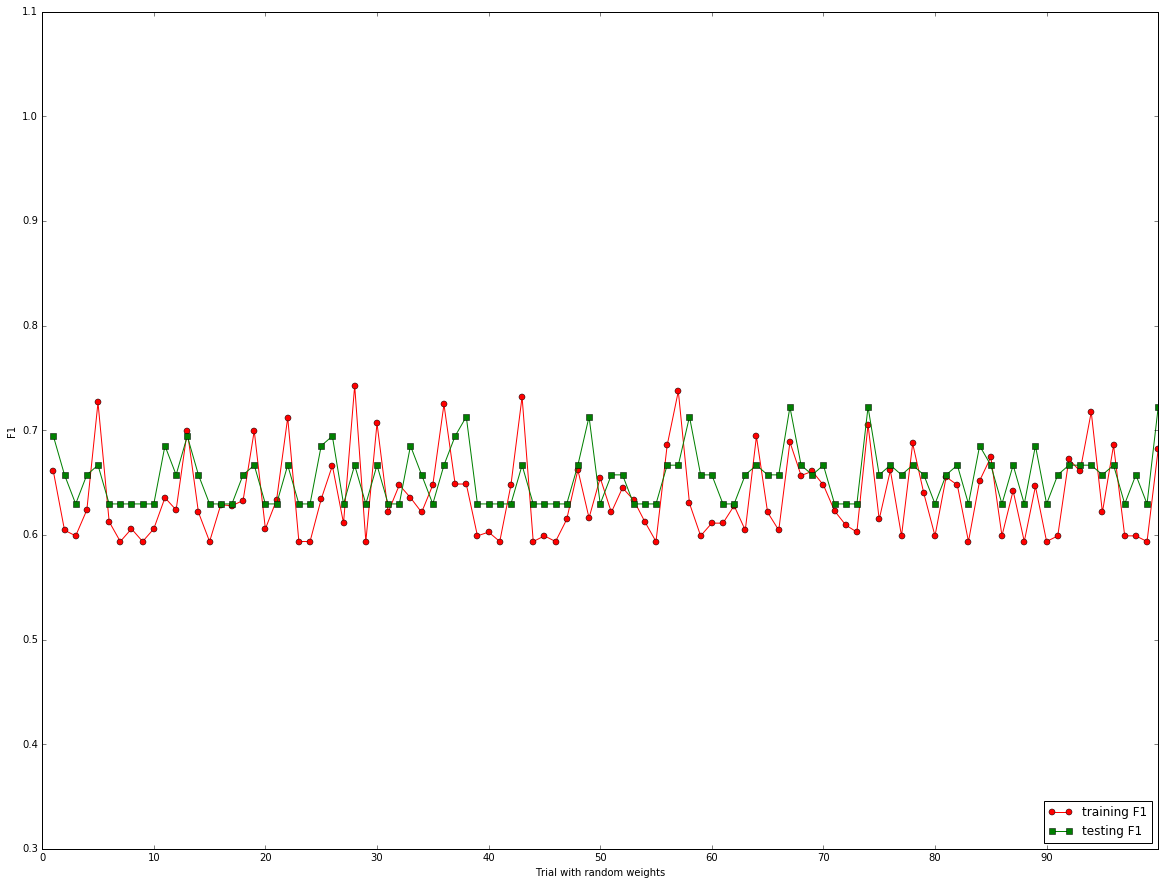

In [298]:
if runRandom:
    plt.figure(figsize=[20, 15])
    #plt.boxplot(F1_train)
    #plt.boxplot(F1_test)
    plt.plot(np.arange(1, len(F1_train)+1), [np.mean(x) for x in F1_train], color='r', marker='o', label='training F1')
    plt.plot(np.arange(1, len(F1_test)+1), [np.mean(x) for x in F1_test], color='g', marker='s', label='testing F1')
    xticks = [10*x for x in range(int(round(len(F1_test), -1)/10))]
    plt.xticks(xticks, xticks) # xticks starts from 1
    plt.ylim([0.3, 1.1])
    plt.xlabel('Trial with random weights')
    plt.ylabel('F1')
    plt.legend(loc='lower right')

### 5.3 Passive Learning: Optimised Weights

In [364]:
(poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter2(\
seqid_set_annotate0, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all)

In [365]:
weights0 = np.random.uniform(-1, 1, 3)
#weights0 = np.array([0.1, 0.1, 0.1])
print(weights0)

[ 0.2963127  -0.49852733  0.36535179]


In [373]:
results = fmin(func=calc_cost2, x0=weights0, maxfun=1e2, \
               args=(seqid_set_annotate0, poi_list, poi_info, seq_all, bins_pop, bins_dist, poi_distmat, \
                     poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat))

Optimization terminated successfully.
         Current function value: 32530.000000
         Iterations: 9
         Function evaluations: 44


In [377]:
print(results)

[ 0.2963127  -0.49852733  0.36535179]


The same weights as the initial guess. The optimisation seems not working as expected.

In [359]:
# x just doesn't move at all, 0 iterations
#optres = minimize(fun=calc_cost1, x0=weights0, method='L-BFGS-B', jac=False, bounds=((-1, 1), (-1, 1), (-1, 1)), \
#                  args=(seqid_set_annotate0, poi_list, poi_info, seq_all, bins_pop, bins_dist, poi_distmat, \
#                        poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat))
#(x, f, d) = fmin_l_bfgs_b(func=calc_cost1, x0=weights0, approx_grad=True, epsilon=1e-6, \
#                          bounds=[(-1, 1), (-1, 1), (-1, 1)], \
#                          args=(seqid_set_annotate0, poi_list, poi_info, seq_all, bins_pop, bins_dist, poi_distmat, \
#                                poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat))
#print('x:', x)
#print('f:', f)
#print('d:', d)

[-0.85155365 -0.72265802 -0.73252187]
x: [-0.85155365 -0.72265802 -0.73252187]
f: 37000.0
d: {'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'nit': 0, 'grad': array([ 0.,  0.,  0.]), 'warnflag': 0, 'funcalls': 4}


In [351]:
optFound = False

In [352]:
#if optres.success:
#    optFound = True
#    print('optimal weights found:', optres.x)
#else:
#    print('optimisation failed!')
#print('status:', optres.status)
#print('message:', optres.message)
#print('#iteration:', optres.nit)

optimal weights found: [ 0.93373706 -0.11054203 -0.27024967]
status: 0
message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
#iteration: 0


In [331]:
if optFound:
    #weights = optres.x
    weights = results[0]
    F1scores_train = evaluate_parallel(seqid_set_annotate0, weights, poi_list, poi_info, seq_all, bins_pop, \
                     bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
    print('F1 train: %.2f, %.2f' % (np.mean(F1scores_train), np.std(F1scores_train)))
    F1scores_test  = evaluate_parallel(seqid_set_evaluate0, weights, poi_list, poi_info, seq_all, bins_pop, \
                     bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
    print('F1 test : %.2f, %.2f' % (np.mean(F1scores_test), np.std(F1scores_test)))

F1 train: 0.71, 0.17
F1 test : 0.67, 0.14


Use a naive iterative random guessing procedure to optimise, return the best guessing.

In [414]:
def optimise_weight(weights0, seqid_set, poi_list, poi_info, seq_all, bins_pop, bins_dist, poi_distmat, \
                    poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat):
    t1 = datetime.now()
    #results = fmin_powell(func=calc_cost2, x0=weights0, \
    #                      args=(seqid_set_annotate0, poi_list, poi_info, seq_all, bins_pop, bins_dist, poi_distmat, \
    #                            poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat))
    #return results
    best = 0
    bestweights = []
    for i in range(30):
        weights = np.random.uniform(-1, 1, 3)
        F1scores_train = evaluate_parallel(seqid_set_annotate0, weights, poi_list, poi_info, seq_all, bins_pop, \
                         bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        meanF1 = np.mean(F1scores_train)
        if meanF1 > best:
            best = meanF1
            bestweights = weights
    print('%d seconds used' % (datetime.now()-t1).total_seconds())
    return bestweights

### 5.2 Random Baseline

Query strategy: choose a random example in annotation set to query (passive learning).

Make a copy of annotation set and use the copy.

In [434]:
seqid_set_training = []
seqid_set_annotate = list(seqid_set_annotate0)
seqid_set_evaluate = list(seqid_set_evaluate0)
weights0 = np.random.uniform(-1, 1, 3)

In [380]:
query_order = np.arange(len(seqid_set_annotate))
np.random.shuffle(query_order)

In [381]:
F1_scores_rand = []
seq_order_rand = []

In [382]:
doCompute = True

In [383]:
if os.path.exists(frand) and os.path.exists(forand):
    doCompute = False
    F1_scores_rand = pickle.load(open(frand, 'rb'))
    seq_order_rand = pickle.load(open(forand, 'rb'))

Sanity check: should be uniform transitions.

In [435]:
#(poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter1(\
#seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all)

In [556]:
#poi_info
#poi_cat_log_transmat
#poi_pop_log_transmat
#poipair_dist_log_transmat

Sanity check: recommend by random guessing, different F1 for different run.

In [552]:
F1scores = evaluate_random(seqid_set_evaluate, poi_list, seq_all)
print('F1 mean: %.2f, std: %.2f' % (np.mean(F1scores), np.std(F1scores)))
print(F1scores)

F1 mean: 0.63, std: 0.07
[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.5, 0.5, 0.6666666666666666]


Sanity check: evaluate using the first example in test set.

In [410]:
if doCompute:
    seqid = seqid_set_evaluate[0]
    seq_act = extract_seq(seqid, seq_all)
    seq_rec_df = recommend_trajectory(seq_act[0], seq_act[-1], len(seq_act), weights0, poi_list, poi_info, bins_pop, \
                 bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
    seq_rec = parse_seqstr(seq_rec_df.iloc[0]['sequence']) # choose the one with max posterior
    F1 = calc_F1score(seq_act, seq_rec) 
    print('Actual: %-23s  Recommended: %-23s F1: %.2f' % (str(seq_act), str(seq_rec), F1))
    seq_rec_df

Actual: [21, 22, 3]              Recommended: [21, 1, 3]              F1: 0.67


Estimate parameters using the initial training set.

In [408]:
if doCompute:
    (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter1(\
     seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all)

Recommend trajectories using the initial training set and evaluate on test set.

In [441]:
if doCompute:
    # no tie-breaking when sorting in recommend_trajectory()
    #F1scores = evaluate_parallel(seqid_set_evaluate, weights0, poi_list, poi_info, seq_all, bins_pop, \
    #                 bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
    F1scores = evaluate_random(seqid_set_evaluate, poi_list, seq_all)
    F1_scores_rand.append(F1scores)
    print('Evaluation 0, F1 mean: %.2f, std: %.2f' % (np.mean(F1_scores_rand[-1]), np.std(F1_scores_rand[-1])))
    sys.stdout.flush()

Evaluate the baseline on test set using random query strategy.

In [413]:
if doCompute:
    n = 1
    weights = weights0
    for idx in query_order:
        # choose sequence to query
        seqid = seqid_set_annotate[idx]
        
        # add query result to training set, here just add the sequence id to training set
        seq_order_rand.append(seqid)
        seqid_set_training.append(seqid)
        
        # estimate parameters using current training set
        (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter1(\
        seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all, \
        poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        
        # optimise weights
        weights = optimise_weight(weights, seqid_set_training, poi_list, poi_info, seq_all, bins_pop, bins_dist, \
                                  poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        
        # evaluate on test set
        F1scores = evaluate_parallel(seqid_set_evaluate, weights, poi_list, poi_info, seq_all, bins_pop, bins_dist, \
                                     poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        F1_scores_rand.append(F1scores)
        print('Evaluation %-2d/%d, F1 mean: %.2f, std: %.2f' % \
              (n, len(seqid_set_annotate0), np.mean(F1_scores_rand[-1]), np.std(F1_scores_rand[-1])))
        sys.stdout.flush()
        n += 1
        
    pickle.dump(F1_scores_rand, open(frand, 'wb'))
    pickle.dump(seq_order_rand, open(forand, 'wb'))

Evaluation 1 /37, F1 mean: 0.67, std: 0.14
Evaluation 2 /37, F1 mean: 0.73, std: 0.16
Evaluation 3 /37, F1 mean: 0.67, std: 0.14
Evaluation 4 /37, F1 mean: 0.63, std: 0.07
Evaluation 5 /37, F1 mean: 0.63, std: 0.07
Evaluation 6 /37, F1 mean: 0.73, std: 0.16
Evaluation 7 /37, F1 mean: 0.73, std: 0.16
Evaluation 8 /37, F1 mean: 0.67, std: 0.14
Evaluation 9 /37, F1 mean: 0.67, std: 0.14
Evaluation 10/37, F1 mean: 0.70, std: 0.17
Evaluation 11/37, F1 mean: 0.69, std: 0.12
Evaluation 12/37, F1 mean: 0.69, std: 0.12
Evaluation 13/37, F1 mean: 0.73, std: 0.16
Evaluation 14/37, F1 mean: 0.73, std: 0.16
Evaluation 15/37, F1 mean: 0.73, std: 0.16
Evaluation 16/37, F1 mean: 0.73, std: 0.16
Evaluation 17/37, F1 mean: 0.74, std: 0.19
Evaluation 18/37, F1 mean: 0.70, std: 0.17
Evaluation 19/37, F1 mean: 0.66, std: 0.06
Evaluation 20/37, F1 mean: 0.78, std: 0.21
Evaluation 21/37, F1 mean: 0.74, std: 0.19
Evaluation 22/37, F1 mean: 0.70, std: 0.17
Evaluation 23/37, F1 mean: 0.74, std: 0.19
Evaluation 

Plot the learning curve.

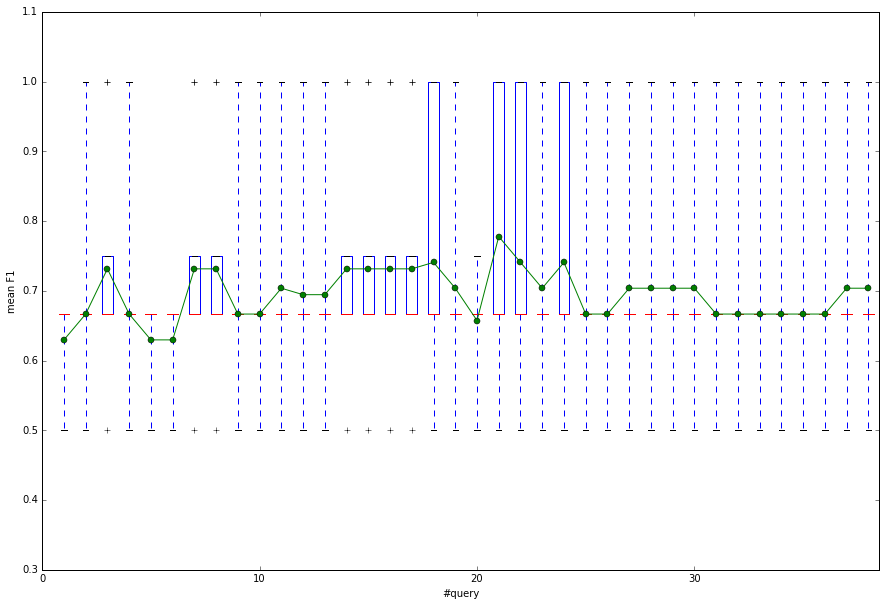

In [557]:
plt.figure(figsize=[15, 10])
plt.boxplot(F1_scores_rand)
plt.plot(np.arange(1, len(F1_scores_rand)+1), [np.mean(x) for x in F1_scores_rand], color='g', marker='o')
#plt.plot(np.arange(len(seqid_set_annotate)+1), F1_random, marker='s', color='g', linestyle='--', label='random baseline')
#plt.errorbar(np.arange(len(seqid_set_annotate0)+1), F1_mean_rand, yerr=F1_std_rand, color='g', \
#             linestyle='--', marker='s', label='random baseline')
plt.ylim([0.3, 1.1])
xticks = [10*x for x in range(int(round(len(F1_scores_rand), -1)/10))]
plt.xticks(xticks, xticks) # xticks starts from 1
plt.xlabel('#query')
plt.ylabel('mean F1')
#plt.legend(loc='lower right')

### 5.3 Least Confident Strategy

Query Strategy:
\begin{equation}
\phi^{LC}(\textbf{x}) = 1 - P(\textbf{y}^* | \textbf{x}; \Theta)
\end{equation}
where $\textbf{y}^*$ is the most likely label of example $\textbf{x}$ with respect to a probabilistic model of which the parameters are denoted by $\Theta$.  
This query strategy select the example $\textbf{x}$ of maximum $\phi^{LC}$ from all unlabelled examples in a pool to query.

**Problem**:
- This query strategy biases to sequences with more POIs, as the number of candidate trajectories grows exponentially as the number of POIs specified, the probability of the most likely candidate trajectory becomes smaller and smaller.

Make a copy of training set and annotation set and use the copies.

In [558]:
seqid_set_training = []
seqid_set_annotate = list(seqid_set_annotate0)
seqid_set_evaluate = list(seqid_set_evaluate0)

In [559]:
F1_scores_lc = []
seq_order_lc = []

In [560]:
doCompute = True

In [561]:
if os.path.exists(flc) and os.path.exists(folc):
    doCompute = False
    F1_scores_lc = pickle.load(open(flc, 'rb'))
    seq_order_lc = pickle.load(open(folc, 'rb'))

Sanity check.

In [562]:
#(poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
#estimate_parameter(seqid_set_training, poi_all, seq_all)

In [563]:
#print(poi_info)
#print(poi_cat_transmat_log)
#print(poi_pop_transmat_log)

In [564]:
#seq_act = [8, 19, 22]
#seq_rec_df = recommend_trajectory(seq_act[0], seq_act[-1], len(seq_act), poi_info, poi_cat_transmat_log, \
#                                  poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
#print(seq_act); print(seq_rec_df); print(); sys.stdout.flush()

Recommend trajectories using the initial training set and evaluate on test set.

In [565]:
if doCompute:
    (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter1(\
     seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all)
    #F1scores = evaluate_parallel(seqid_set_evaluate, weights0, poi_list, poi_info, seq_all, bins_pop, \
    #           bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
    F1scores = evaluate_random(seqid_set_evaluate, poi_list, seq_all)
    F1_scores_lc.append(F1scores)
    print('Evaluation 0, F1 mean: %.2f, std: %.2f' % (np.mean(F1_scores_lc[-1]), np.std(F1_scores_lc[-1])))
    sys.stdout.flush()

Evaluate on test set using least confident query strategy.

In [566]:
if doCompute:
    n = 1
    seqs_annotate = [extract_seq(seqid, seq_all) for seqid in seqid_set_annotate]
    weights = weights0
    # repeat until all sequences in annotation set have been queried 
    while len(seqid_set_annotate) > 0:
        # parallel
        seq_rec_df_list = Parallel(n_jobs=-2)(delayed(recommend_trajectory)\
                          (seq[0], seq[-1], len(seq), weights, poi_list, poi_info, bins_pop, bins_dist, poi_distmat, \
                           poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) \
                          for seq in seqs_annotate)
        maxprobs = np.array([seq_rec_df.iloc[0]['probability'] for seq_rec_df in seq_rec_df_list])
        assert(np.any(np.isnan(maxprobs)) == False) # No NaN value
        #lc = 1 - maxprobs; seq_idx = np.argmax(lc)
        seq_idx = np.argmin(maxprobs)

        # add query result to training set, here just add the sequence id to training set
        seq_order_lc.append(seqid_set_annotate[seq_idx])
        seqid_set_training.append(seqid_set_annotate[seq_idx])
        print('Choose sequence %23s, LC: %.4f' % (str(seqs_annotate[seq_idx]), 1-maxprobs[seq_idx])); sys.stdout.flush()

        # remove the selected example from annotation set
        del seqid_set_annotate[seq_idx]
        del seqs_annotate[seq_idx]

        # estimate parameters using current training set
        (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter1(\
        seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all, \
        poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        
        # optimise weights
        weights = optimise_weight(weights, seqid_set_training, poi_list, poi_info, seq_all, bins_pop, bins_dist, \
                                  poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
 
        # evaluate on test set
        F1scores = evaluate_parallel(seqid_set_evaluate, weights, poi_list, poi_info, seq_all, bins_pop, bins_dist, \
                                     poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)

        F1_scores_lc.append(F1scores)
        print('Evaluation %-3d/%d, F1 mean: %.2f, std: %.2f' % \
              (n, len(seqid_set_annotate0), np.mean(F1_scores_lc[-1]), np.std(F1_scores_lc[-1])))
        sys.stdout.flush()
        n += 1
        
    pickle.dump(F1_scores_lc, open(flc, 'wb'))
    pickle.dump(seq_order_lc, open(folc, 'wb'))

Plot the learning curve.

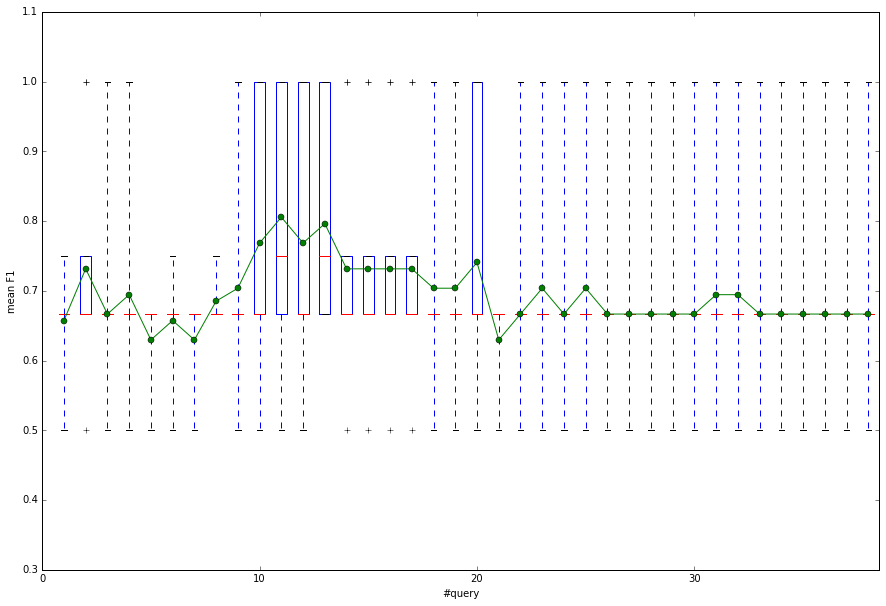

In [569]:
plt.figure(figsize=[15, 10])
plt.boxplot(F1_scores_lc, labels=np.arange(len(F1_scores_lc)))
plt.plot(np.arange(1, len(F1_scores_lc)+1), [np.mean(x) for x in F1_scores_lc], color='g', marker='o')
#plt.errorbar(np.arange(len(seqid_set_annotate0)+1), F1_mean_lc, yerr=F1_std_lc, \
#             linestyle='--', marker='s', label='least confident')
xticks = [10*x for x in range(int(round(len(F1_scores_lc), -1)/10))]
plt.xticks(xticks, xticks) # xticks starts from 1
plt.ylim([0.3, 1.1])
plt.xlabel('#query')
plt.ylabel('mean F1')
#plt.legend(loc='lower right')

### 5.4 Maximum Sequence Entropy Strategy

\begin{equation}
\phi^{SE}(\textbf{x}) = - \sum_{\hat{\textbf{y}}} P(\hat{\textbf{y}} | \textbf{x}; \Theta) 
\log(P(\hat{\textbf{y}} | \textbf{x}; \Theta))
\end{equation}
where $\hat{\textbf{y}}$ ranges over all possible labels for example $\textbf{x}$.  
**Note** that the number of possible labels grows exponentially with $|Traj|$ in $\textbf{x}$, to make computation feasible,
[Kim06](http://www.aclweb.org/anthology/N06-2018) used the $N$-best possible labels to approximate, concretely, 
define **N-best Sequence Entropy** as
\begin{equation}
\phi^{NSE}(\textbf{x}) = - \sum_{\hat{\textbf{y}} \in \mathcal{N}} P(\hat{\textbf{y}} | \textbf{x}; \Theta) 
\log(P(\hat{\textbf{y}} | \textbf{x}; \Theta))
\end{equation}
where $\mathcal{N} = \{\textbf{y}_1^*, \dots, \textbf{y}_N^*\}$ is the set of the $N$ most likely labels of example $\textbf{x}$.  
This query strategy select the example $\textbf{x}$ of maximum $\phi^{SE}$ or $\phi^{NSE}$ from all unlabelled examples in a pool to query.

Make a copy of training set and annotation set and use the copies.

In [570]:
seqid_set_training = []
seqid_set_annotate = list(seqid_set_annotate0)
seqid_set_evaluate = list(seqid_set_evaluate0)

In [571]:
F1_scores_se = []
seq_order_se = []

In [572]:
doCompute = True

In [573]:
if os.path.exists(fse) and os.path.exists(fose):
    doCompute = False
    F1_scores_se = pickle.load(open(fse, 'rb'))
    seq_order_se = pickle.load(open(fose, 'rb'))

Recommend trajectories using the initial training set and evaluate on test set.

In [574]:
if doCompute:
    (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter1(\
     seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all)
    #F1scores = evaluate_parallel(seqid_set_evaluate, weights0, poi_list, poi_info, seq_all, bins_pop, \
    #           bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
    F1scores = evaluate_random(seqid_set_evaluate, poi_list, seq_all)
    F1_scores_se.append(F1scores)
    print('Evaluation 0, F1 mean: %.2f, std: %.2f' % (np.mean(F1_scores_se[-1]), np.std(F1_scores_se[-1])))
    sys.stdout.flush()

Compute sequence entropy.

In [575]:
def calc_sequence_entropy(start, end, length, weights, poi_list, poi_info, poi_all, bins_pop, bins_dist, poi_distmat,\
                          poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat):
    # enumerate trajectory
    enum_seqs = enum_seq345(start, end, length, poi_list)

    # sequential
    logL = []
    for seq in enum_seqs:
        logl = calc_seq_loglikelihood(seq, weights, poi_all, poi_info, bins_pop, bins_dist, poi_distmat, \
                                      poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        logL.append(logl)
    
    probs = np.array(logL)
    probs = np.exp(probs)
    probs /= np.sum(probs) # normalise
    
    return -1 * np.dot(probs, np.log(probs))

Evaluate on test set using sequence entropy query strategy.

In [576]:
if doCompute:
    n = 1
    weights = weights0
    seqs_annotate = [extract_seq(seqid, seq_all) for seqid in seqid_set_annotate]
    # repeat until all sequences in annotation set have been queried 
    while len(seqid_set_annotate) > 0:
        # choose sequence to query
        seq_entropy_list = Parallel(n_jobs=-2)(delayed(calc_sequence_entropy)\
                           (seq[0], seq[-1], len(seq), weights, poi_list, poi_info, poi_all, bins_pop, bins_dist, \
                            poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) \
                           for seq in seqs_annotate)
        assert(np.any(np.isnan(np.array(seq_entropy_list))) == False) # No NaN value
        seq_idx = np.argmax(np.array(seq_entropy_list))

        # add query result to training set, here just add the sequence id to training set
        seq_order_se.append(seqid_set_annotate[seq_idx])
        seqid_set_training.append(seqid_set_annotate[seq_idx])
        print('Choose sequence %23s, SE: %.4f' % (str(seqs_annotate[seq_idx]), seq_entropy_list[seq_idx]))
        sys.stdout.flush()

        # remove the selected example from annotation set
        del seqid_set_annotate[seq_idx]
        del seqs_annotate[seq_idx]

        # estimate parameters using current training set
        (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter1(\
        seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all, \
        poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        
        # optimise weights
        weights = optimise_weight(weights, seqid_set_training, poi_list, poi_info, seq_all, bins_pop, bins_dist, \
                                  poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
 
        # evaluate on test set
        F1scores = evaluate_parallel(seqid_set_evaluate, weights, poi_list, poi_info, seq_all, bins_pop, bins_dist, \
                                     poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        F1_scores_se.append(F1scores)
        print('Evaluation %-3d/%d, F1 mean: %.2f, std: %.2f' % \
              (n, len(seqid_set_annotate0), np.mean(F1_scores_se[-1]), np.std(F1_scores_se[-1])))
        sys.stdout.flush()
        n += 1
        
    pickle.dump(F1_scores_se, open(fse, 'wb'))
    pickle.dump(seq_order_se, open(fose, 'wb'))    

Plot the learning curve.

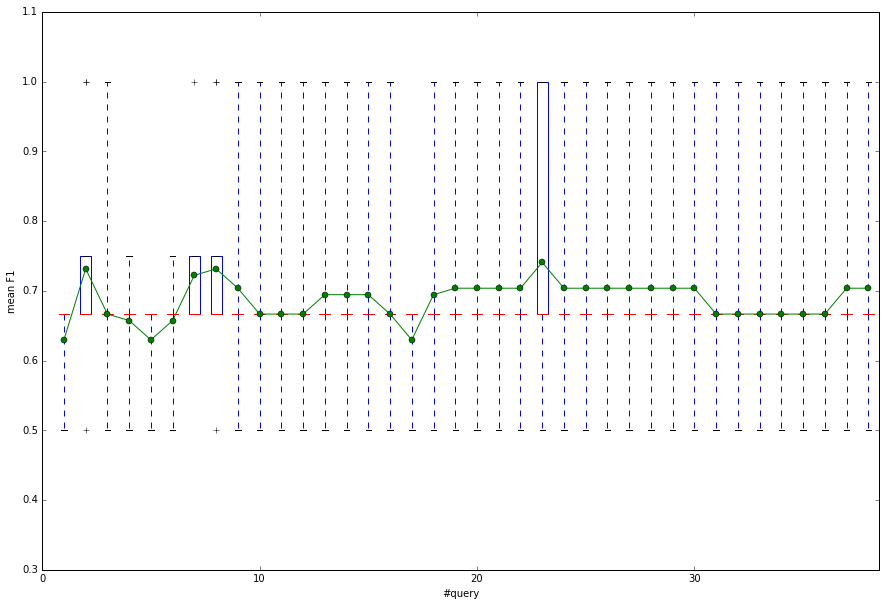

In [577]:
plt.figure(figsize=[15, 10])
plt.boxplot(F1_scores_se)
plt.plot(np.arange(1, len(F1_scores_se)+1), [np.mean(x) for x in F1_scores_se], color='g', marker='o')
xticks = [10*x for x in range(int(round(len(F1_scores_se), -1)/10))]
plt.xticks(xticks, xticks) # xticks starts from 1
plt.ylim([0.3, 1.1])
plt.xlabel('#query')
plt.ylabel('mean F1')
#plt.legend(loc='lower right')

### 5.5 Maximum Information Density Strategy

\begin{equation}
\phi^{ID}(\textbf{x}) = \phi^{SE}(\textbf{x}) \times 
\left(
\frac{1}{U} \sum_{u=1}^U \text{sim}(\textbf{x}, \textbf{x}^u)
\right)^\beta
\end{equation}
That is, the informativeness of example $\textbf{x}$ is weighted by its average similarity to all other unlabelled examples (denoted by $\mathcal{U})$ in the pool, subject to parameter $\beta$ which was set to $1$ in [Settles08](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.187.7401&rep=rep1&type=pdf) giving no reason, 
sequence entropy $\phi^{SE}$ measures the "base" informativeness and could be replaced by $\phi^{NSE}$ defined above.  
This query strategy select the example $\textbf{x}$ of maximum $\phi^{ID}$ from all unlabelled examples in a pool to query.

Define a function to compute the simularity between two trajectories, [Settles08](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.187.7401&rep=rep1&type=pdf) uses cosine simularity after transforming a sequence into a fixed length feature vector.

Let sequence $i$ $[p_{i_1}, p_{i_2}, \dots, p_{i_{N1}}]$ and sequence $j$ $[p_{j_1}, p_{j_2}, \dots, p_{j_{N1}}]$,
define the similarity between sequence $i$ and $j$ as follows:
\begin{equation}
\text{sim}([p_{i_1}, p_{i_2}, \dots, p_{i_{N1}}], [p_{j_1}, p_{j_2}, \dots, p_{j_{N1}}]) = 
\frac{\lvert [p_{i_1}, p_{i_2}, \dots, p_{i_{N1}}] \cap [p_{j_1}, p_{j_2}, \dots, p_{j_{N1}}] \rvert}
     {\lvert [p_{i_1}, p_{i_2}, \dots, p_{i_{N1}}] \cup [p_{j_1}, p_{j_2}, \dots, p_{j_{N1}}] \rvert}
\end{equation}

In [ ]:
def calc_sequence_similarity(seq1, seq2):
    assert(len(seq1) > 0 and len(seq2) > 0)
    return len(set(seq1) & set(seq2)) / len(set(seq1) | set(seq2))

Make a copy of training set and annotation set and use the copies.

In [ ]:
seqid_set_training = []
seqid_set_annotate = list(seqid_set_annotate0)
seqid_set_evaluate = list(seqid_set_evaluate0)

Compute the simularity between all pair of unlabelled exmaples.  
**NOTE** that there are duplicate sequences exist.

In [ ]:
distinct_seqstr_list = {str(extract_seq(seqid, seq_all)) for seqid in seqid_set_annotate0}
seqs_annotate0 = [parse_seqstr(seqstr) for seqstr in sorted(distinct_seqstr_list)] # distinct sequences
seq_sim_mat = pd.DataFrame(data=np.zeros((len(seqs_annotate0), len(seqs_annotate0)), dtype=np.float), \
                           index=[str(x) for x in seqs_annotate0], columns=[str(x) for x in seqs_annotate0])
for i in range(len(seqs_annotate0)):
    for j in range(i, len(seqs_annotate0)):
        sim = calc_sequence_similarity(seqs_annotate0[i], seqs_annotate0[j])
        assert(not np.isnan(sim))
        seq_sim_mat.iloc[i, j] = sim
        seq_sim_mat.iloc[j, i] = sim

Sanity check.

In [ ]:
#seq_sim_mat.head()

In [ ]:
#k = 5
#sumk = seq_sim_mat.iloc[k].sum()
#sumk /= len(seqs_annotate0)
#sumk = sumk**1
#print(sumk)

In [ ]:
#sums=[(np.sum([seq_sim_mat.loc[str(x), str(y)] for y in seqs_annotate0])/len(seqs_annotate0))**1 for x in seqs_annotate0]
#sums

In [ ]:
F1_scores_id = []
seq_order_id = []

In [ ]:
doCompute = True

In [ ]:
if os.path.exists(fid) and os.path.exists(foid):
    doCompute = False
    F1_scores_id = pickle.load(open(fid, 'rb'))
    seq_order_id = pickle.load(open(foid, 'rb'))

Recommend trajectories using the initial training set and evaluate on test set.

In [ ]:
if doCompute:
    (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter1(\
     seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all)
    #F1scores = evaluate_parallel(seqid_set_evaluate, weights0, poi_list, poi_info, seq_all, bins_pop, \
    #           bins_dist, poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
    F1scores = evaluate_random(seqid_set_evaluate, poi_list, seq_all)
    F1_scores_id.append(F1scores)
    print('Evaluation 0, F1 mean: %.2f, std: %.2f' % (np.mean(F1_scores_id[-1]), np.std(F1_scores_id[-1])))
    sys.stdout.flush()

Evaluate on test set using information density query strategy.

In [ ]:
if doCompute:
    n = 1
    beta = 1
    weights = weights0
    seqs_annotate = [extract_seq(seqid, seq_all) for seqid in seqid_set_annotate]
    # repeat until all sequences in annotation set have been queried 
    while len(seqid_set_annotate) > 0:
        # choose sequence to query
        seq_entropy_list = Parallel(n_jobs=-2)(delayed(calc_sequence_entropy)\
                           (seq[0], seq[-1], len(seq), weights, poi_list, poi_info, poi_all, bins_pop, bins_dist, \
                            poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) \
                           for seq in seqs_annotate)        
        assert(np.any(np.isnan(np.array(seq_entropy_list))) == False) # No NaN value
        seq_sim_list = [(np.sum([seq_sim_mat.loc[str(x), str(y)] for y in seqs_annotate])/len(seqs_annotate))**beta \
                        for x in seqs_annotate]
        assert(len(seq_entropy_list) == len(seq_sim_list))
        seq_ids = np.multiply(np.array(seq_entropy_list), np.array(seq_sim_list))
        seq_idx = np.argmax(seq_ids)

        # add query result to training set, here just add the sequence id to training set
        seq_order_id.append(seqid_set_annotate[seq_idx])
        seqid_set_training.append(seqid_set_annotate[seq_idx])
        print('Choose sequence %23s, ID:%.4f' % (str(seqs_annotate[seq_idx]), seq_ids[seq_idx]))
        sys.stdout.flush()

        # remove the selected example from annotation set
        del seqid_set_annotate[seq_idx]
        del seqs_annotate[seq_idx]

        # estimate parameters using current training set
        (poi_info, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat) = estimate_parameter1(\
        seqid_set_training, poi_cats, bins_pop, bins_dist, poi_distmat, poi_all, seq_all, \
        poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        
        # optimise weights
        weights = optimise_weight(weights, seqid_set_training, poi_list, poi_info, seq_all, bins_pop, bins_dist, \
                                  poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
 
        # evaluate on test set
        F1scores = evaluate_parallel(seqid_set_evaluate, weights, poi_list, poi_info, seq_all, bins_pop, bins_dist, \
                                     poi_distmat, poi_cat_log_transmat, poi_pop_log_transmat, poipair_dist_log_transmat)
        F1_scores_id.append(F1scores)
        print('Evaluation %-3d/%d, F1 mean: %.2f, std: %.2f' % \
              (n, len(seqid_set_annotate0), np.mean(F1_scores_id[-1]), np.std(F1_scores_id[-1])))
        sys.stdout.flush()
        n += 1
        
    pickle.dump(F1_scores_id, open(fse, 'wb'))
    pickle.dump(seq_order_id, open(fose, 'wb'))

Plot the learning curve.

In [ ]:
plt.figure(figsize=[20, 15])
plt.boxplot(F1_scores_id)
plt.plot(np.arange(1, len(F1_scores_id)+1), [np.mean(x) for x in F1_scores_id], color='g', marker='s')
xticks = [10*x for x in range(int(round(len(F1_scores_id), -1)/10))]
plt.xticks(xticks, xticks) # xticks starts from 1
plt.ylim([0.6, 0.85])
plt.xlabel('#query')
plt.ylabel('mean F1')
#plt.legend(loc='lower right')

### 5.6 Performance Comparison

Random guessing probability on test set.

In [430]:
#n3 = seq_stats[seq_stats['seqLen'] == 3].shape[0]
#n4 = seq_stats[seq_stats['seqLen'] == 4].shape[0]
#n5 = seq_stats[seq_stats['seqLen'] == 5].shape[0]
#nseq = n3 + n4 + n5
#npoi = seq_all[seq_all['seqID'].isin(seqid_set_exp)]['poiID'].unique().shape[0]

In [543]:
test_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_evaluate0]
n3 = np.sum(np.array([len(seq) for seq in test_seqs]) == 3)
n4 = np.sum(np.array([len(seq) for seq in test_seqs]) == 4)
n5 = np.sum(np.array([len(seq) for seq in test_seqs]) == 5)
nseq = n3 + n4 + n5
npoi = len(poi_list)
print('npoi: %d, n3: %d, n4: %d, n5: %d, nseq: %d, %d' % (npoi, n3, n4, n5, nseq, len(test_seqs)))

npoi: 21, n3: 7, n4: 2, n5: 0, nseq: 9, 9


In [544]:
from scipy.misc import comb
from math import factorial
prob3 = (1*comb(1, 1) + (2/3)*comb(npoi-3, 1)) / (npoi-2)
prob4 = (1*comb(2, 2) + (3/4)*comb(2, 1)*comb(npoi-4, 1) + (2/4)*comb(npoi-4, 2)) * factorial(2) / ((npoi-2) * (npoi-3))
prob5 = (1*comb(3, 3) + (4/5)*comb(3, 2)*comb(npoi-5, 1) + (3/5)*comb(3, 1)*comb(npoi-5, 2) + (2/5)*comb(npoi-5, 3)) * \
        factorial(3) / ((npoi-2) * (npoi-3) * (npoi-4))

In [545]:
randguess = prob3 * (n3 / nseq) + prob4 * (n4 / nseq) + prob5 * (n5 / nseq)
print(randguess)

0.654970760234


Compare learning curves using the mean of F1.

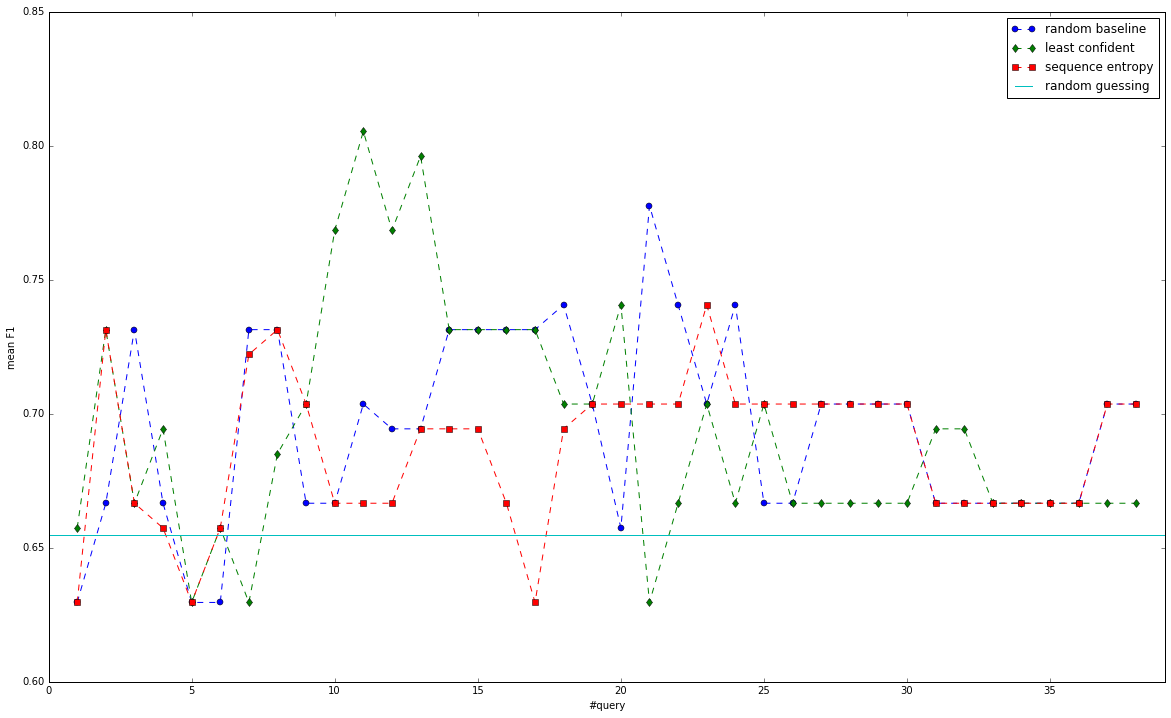

In [585]:
plt.figure(figsize=[20, 12])
plt.plot(np.arange(1, len(F1_scores_rand)+1), [np.mean(x) for x in F1_scores_rand], ls='--', marker='o', label='random baseline')
plt.plot(np.arange(1, len(F1_scores_lc)+1),   [np.mean(x) for x in F1_scores_lc],   ls='--', marker='d', label='least confident')
plt.plot(np.arange(1, len(F1_scores_se)+1),   [np.mean(x) for x in F1_scores_se],   ls='--', marker='s', label='sequence entropy')
#plt.plot(np.arange(len(F1_scores_id)),   [np.mean(x) for x in F1_scores_id],   ls='--', marker='^', label='information density')
plt.plot([0, len(F1_scores_rand)+1], [randguess, randguess], linestyle='-', label='random guessing')
plt.xlim([0, len(F1_scores_rand)+1])
plt.ylim([0.6, 0.85])
plt.xlabel('#query')
plt.ylabel('mean F1')
plt.legend(loc='upper right')

Compare learning curves using the median of F1.

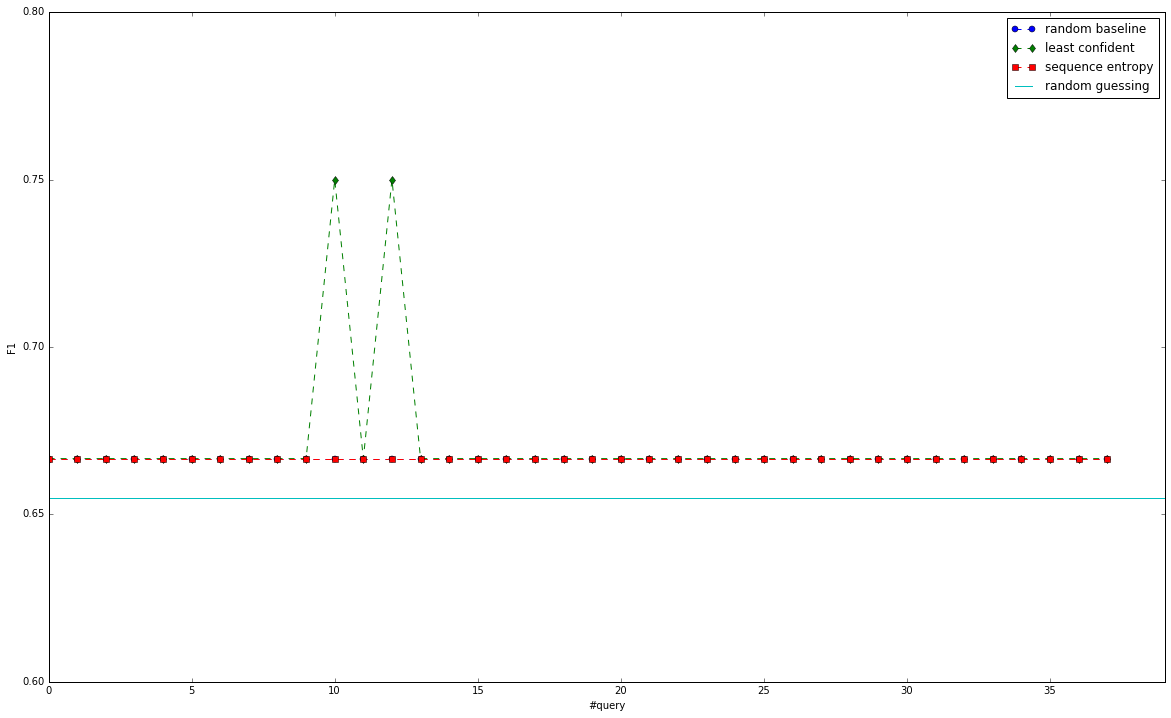

In [584]:
plt.figure(figsize=[20, 12])
plt.plot(np.arange(len(F1_scores_rand)), [np.median(x) for x in F1_scores_rand], ls='--', marker='o', label='random baseline')
plt.plot(np.arange(len(F1_scores_lc)),   [np.median(x) for x in F1_scores_lc],   ls='--', marker='d', label='least confident')
plt.plot(np.arange(len(F1_scores_se)),   [np.median(x) for x in F1_scores_se],   ls='--', marker='s', label='sequence entropy')
#plt.plot(np.arange(len(F1_scores_id)),   [np.median(x) for x in F1_scores_id],   ls='--', marker='^', label='information density')
plt.plot([0, len(F1_scores_rand)+1], [randguess, randguess], linestyle='-', label='random guessing')
plt.xlim([0, len(F1_scores_rand)+1])
plt.ylim([0.6, 0.8])
plt.xlabel('#query')
plt.ylabel('F1')
plt.legend(loc='upper right')